In [2]:
import pandas as pd
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout

from warnings import filterwarnings
filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_dir = "/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train"
test_dir = "/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test"

classes_train = os.listdir(train_dir)
classes_test = os.listdir(test_dir)

In [4]:
# Classes do nosso dataset
print(classes_train)
print(classes_test)

['PNEUMONIA', 'NORMAL']
['PNEUMONIA', 'NORMAL']


# Functions

In [5]:
# Função que será usada para prevermos algumas imagens do dataset de teste
def plot_prediction(test_generator, n_images):
    i = 1
    images, labels = test_generator.next()
    predictions = np.argmax(model.predict(images), axis=1)
    labels = labels.astype('int32')
    
    plt.figure(figsize=(12, 16))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        
        if predictions[i] == labels[i]:
            title_obj = plt.title(classes[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(classes[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        
        if i == n_images+1:
            break

    plt.show()

# Dataset Analysis

In [6]:
train_dict = {}
test_dict = {}

for classe in classes_train:
    train_dict[classe] = len(os.listdir(os.path.join(train_dir, classe)))
    
for classe in classes_test:
    test_dict[classe] = len(os.listdir(os.path.join(test_dir, classe)))

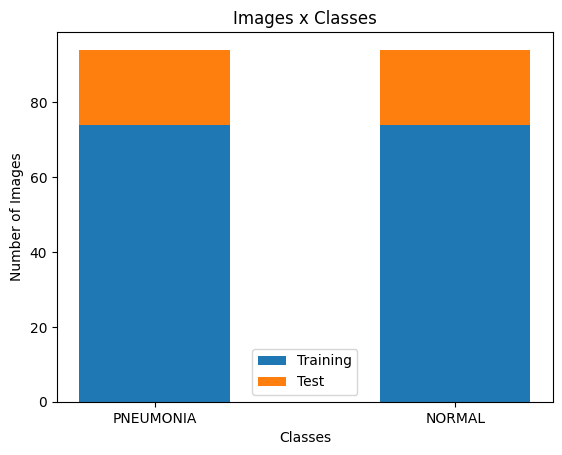

In [7]:
classes = ['PNEUMONIA', 'NORMAL']

train_values = [train_dict[class_name] for class_name in classes]
test_values = [test_dict[class_name] for class_name in classes]

plt.bar(range(len(classes)), train_values, width=0.5, label='Training')
plt.bar(range(len(classes)), test_values, width=0.5, bottom=train_values, label='Test')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Images x Classes')
plt.xticks(range(len(classes)), classes)
plt.legend()
plt.show()

We can see that our dataset is small but very proportional in relation to classes.

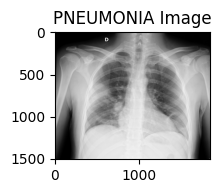

In [8]:
image = cv2.imread(f"{train_dir}/PNEUMONIA/CD50BA96-6982-4C80-AE7B-5F67ACDBFA56.jpeg")

plt.figure(figsize=(2, 5))
plt.imshow(image)
plt.title("PNEUMONIA Image")
plt.show()

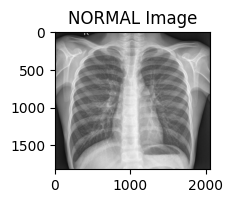

In [9]:
image = cv2.imread(f"{train_dir}/NORMAL/IM-0007-0001.jpeg")

plt.figure(figsize=(2, 5))
plt.imshow(image)
plt.title("NORMAL Image")
plt.show()

# Data Augmentation

In [10]:
# train
train_datagen = ImageDataGenerator(
    zoom_range = 0.1,
    horizontal_flip = True,
    rescale = 1.0/255.0,
    width_shift_range = 0.10,
    height_shift_range = 0.10,
    shear_range = 0.1,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    class_mode = 'binary',
    color_mode = 'rgb',
    batch_size = 32,
    target_size = (1000, 1000)
)

Found 148 images belonging to 2 classes.


Here, we used ImageDataGenerator to make some tweaks to our training dataset, adding some variety to the data so that our model can learn even better.

We also set the number of mini-batches (32), which is the batch size per iteration during model training.

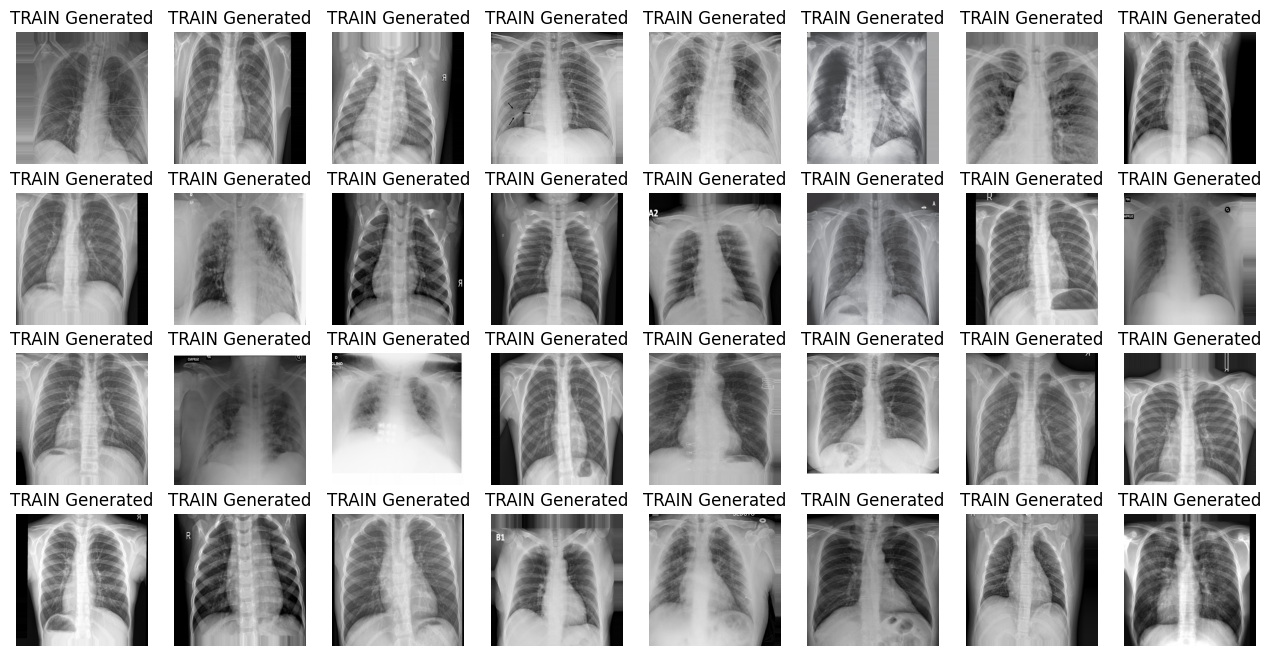

In [11]:
batch_images, batch_labels = next(train_generator)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

axes = axes.flatten()

for i in range(32):
    axes[i].imshow(batch_images[i])
    axes[i].set_title("TRAIN Generated")
    
for ax in axes:
    ax.axis('off')

plt.show()

In [12]:
# test
test_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
)

test_generator = train_datagen.flow_from_directory(
    test_dir,
    class_mode = 'binary',
    color_mode = 'rgb',
    batch_size = 32,
    target_size = (1000, 1000)
)

Found 40 images belonging to 2 classes.


here we just changed scales of our test images

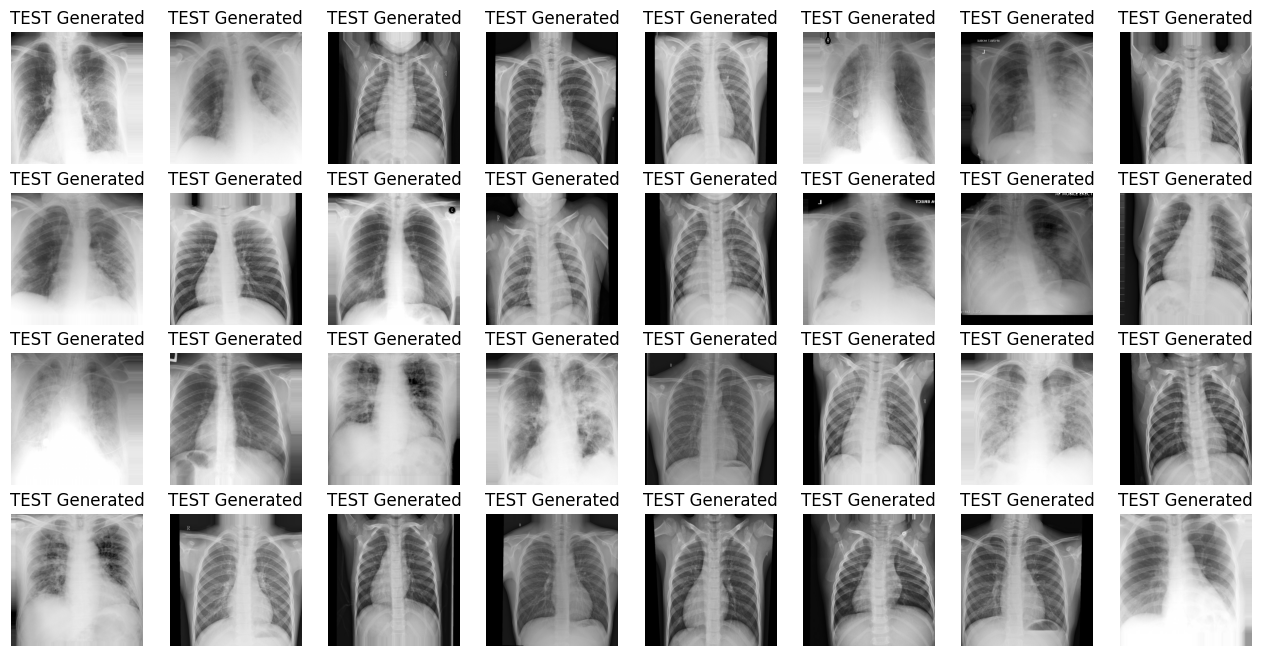

In [13]:
batch_images, batch_labels = next(test_generator)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

axes = axes.flatten()

for i in range(32):
    axes[i].imshow(batch_images[i])
    axes[i].set_title("TEST Generated")
    
for ax in axes:
    ax.axis('off')

plt.show()

# CallBacks

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_acc',
    patience= 3,
    verbose = 1,
    factor = 0.5,
    min_lr = 0.00001
)

callbacks_list = [early_stop, learning_rate_reduction]

Callbacks are functions we give to our model during training to make our lives easier and use less processing.

- Here, for example, we use EarlyStopping with patience=5 and monitor='val_loss', that means when 5 consecutive epochs have the same val_loss value, our model stops the traing right there.
- We also use ReduceLROnPlateau (Reduce Learning Rate On Plateau), it means that when the model stops improving during 3 consecutive times, the learning rate will decrease 0.5, but not ultrapassing the minimum that is 0.00001.

# Model

In [34]:
model = Sequential([
    # cnn
    Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(1000, 1000, 3)),
    MaxPooling2D((5, 5)),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D((5, 5)),
    Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D((5, 5)),
    
    # dense
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

In [36]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 996, 996, 32)      2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 199, 199, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 195, 195, 64)      51264     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 39, 39, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 35, 35, 128)       204928    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 128)       

In [38]:
history = model.fit(
    train_generator, 
    epochs = 10,
    validation_data = test_generator,
    callbacks = callbacks_list
)

Epoch 1/10
5/5 [==============================] - 49s 11s/step - loss: 0.7417 - accuracy: 0.5338 - val_loss: 0.6918 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
5/5 [==============================] - 41s 8s/step - loss: 0.7002 - accuracy: 0.4932 - val_loss: 0.6879 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
5/5 [==============================] - 41s 8s/step - loss: 0.6895 - accuracy: 0.5000 - val_loss: 0.6760 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
5/5 [==============================] - 40s 8s/step - loss: 0.6759 - accuracy: 0.5203 - val_loss: 0.6300 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
5/5 [==============================] - 41s 8s/step - loss: 0.6179 - accuracy: 0.7432 - val_loss: 0.4869 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 6/10
5/5 [==============================] - 40s 9s/step - loss: 0.5975 - accuracy: 0.6824 - val_loss: 0.4311 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 7/10
5/5 [==============================] - 41s 8s/step - loss: 0.5133 - accuracy: 0.77

In [39]:
model.evaluate(test_generator)

2/2 [==============================] - 9s 2s/step - loss: 0.0408 - accuracy: 1.0000


[0.040823303163051605, 1.0]

Here is the accuracy of our model.

In [40]:
losses = pd.DataFrame(history.history)
losses.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.741730,0.533784,0.691815,0.500,0.001
1,0.700208,0.493243,0.687872,0.500,0.001
2,0.689482,0.500000,0.676012,0.500,0.001
3,0.675932,0.520270,0.630005,1.000,0.001
4,0.617938,0.743243,0.486907,0.925,0.001


<Axes: >

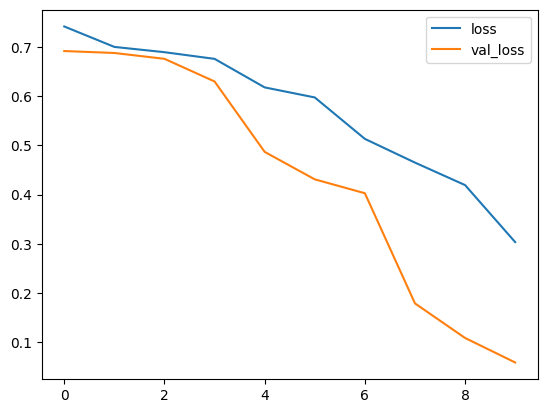

In [41]:
losses[['loss','val_loss']].plot()

The loss evalution was greater than val_loss evalution, it means that on test data there were more errors.

<Axes: >

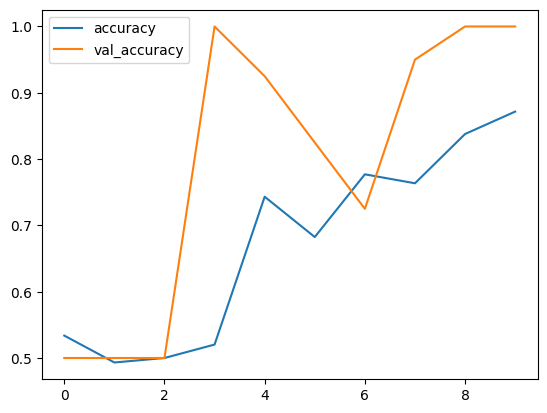

In [42]:
losses[['accuracy','val_accuracy']].plot()

<Axes: >

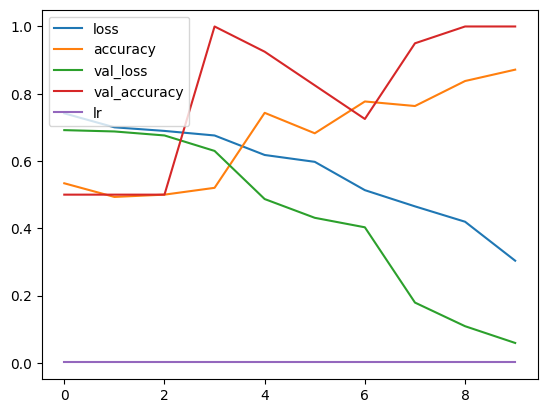

In [44]:
losses.plot()

1/1 [==============================] - 1s 796ms/step


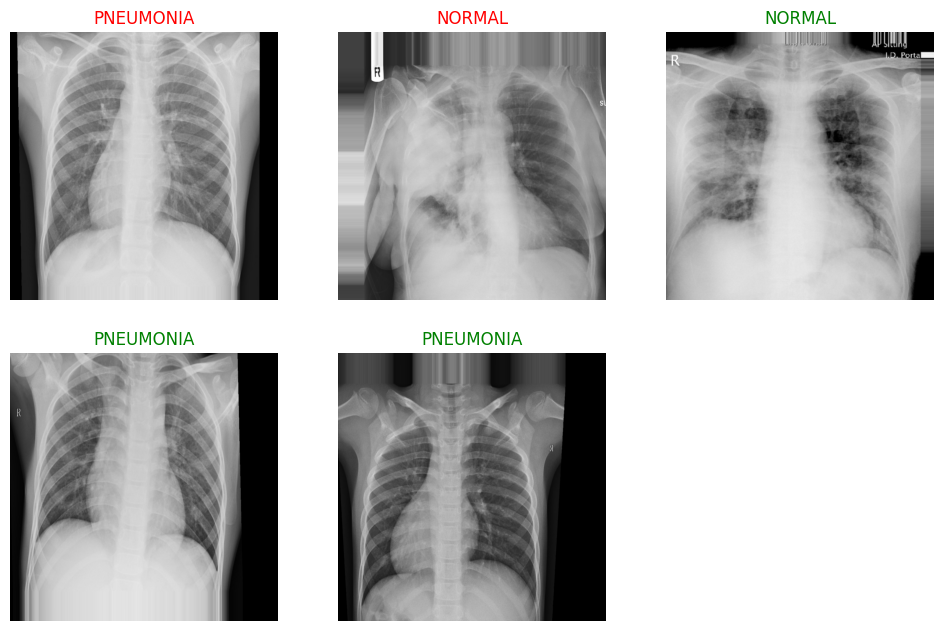

In [45]:
plot_prediction(test_generator, 5)

The names in green represent correct predictions, while those in red indicate incorrect predictions.